# Lab assignment: indoor image classification

<img src="img/indoor_outdoor.png" style="width:800px;">

In this assignment we will face an image classification problem, trying to tell apart images taken indoors from images taken on the outside. To do so we will use an SVM and a Deep Learning approach, comparing both methods.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>This is a hint or useful observation that can help you solve this assignment. You should pay attention to these hints to better understand the assignment.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>This is an advanced and voluntary exercise that can help you gain a deeper knowledge into the topic. Good luck!</td></tr>
</table>

During the assigment you will make use of several Python packages that might not be installed in your machine. If that is the case, you can install new Python packages with

    conda install PACKAGENAME
    
if you are using Python Anaconda. Else you should use

    pip install PACKAGENAME

You will need the following packages for this particular assignment. Make sure they are available before proceeding:

* **numpy**
* **matplotlib**
* **scikit-learn**
* **keras**

The following code will embed any plots into the notebook instead of generating a new window:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Preliminaries: data loading and image representation

In this assignment we will work with the images contained in the following folder:

In [2]:
datafolder = "./data/"

Two subfolders exist: one containing a range of indoor images and another one with outdoor images. We can load an image into python by making use of:

In [3]:
from scipy.misc import imread

path = datafolder + "indoor/1.jpg"
image1 = imread(path)

This returns the image as 3-dimensional numpy matrix, containing the value of intensity of every pixel in each row, column and color channel.

In [4]:
image1.shape

(781, 1037, 3)

We can visualize the loaded image using

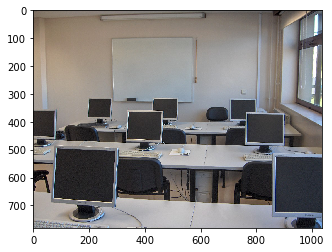

In [5]:
plt.imshow(image1)

Note that the 3rd dimension of our image objects is the pixel intensity. This is divided into 3 **color channels**: those belonging to the red (R), green (G) and blue (B) intensities (**RGB** scheme). Each of these intensities ranges from 0 to 255, since these are 24-bit images: each of the 3 colors is represented by 8 bits, so they can range from 0 (all 8 bits set to 0) to 255 (all 8 bits set to 1). Let us define constants for this:

In [6]:
COLORS = ('r','g','b')
COLOR_MIN_VALUE = 0
COLOR_MAX_VALUE = 255
COLOR_NUM_VALUES = COLOR_MAX_VALUE - COLOR_MIN_VALUE + 1

When R, G and B are all zero, the pixel is totally black. When they are all 255, the pixel is totally white. Pure red is (255, 0, 0), pure green (0, 255, 0) and pure blue (0, 0, 255). Intermediate colors have intermediate values, according to what the specific pixel is. For example, let us manipulate the colors of the previous image:

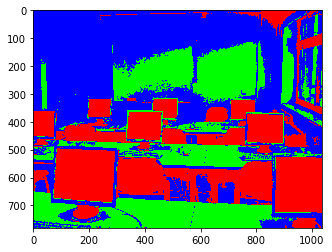

In [7]:
# Tolerance for white and black
tol = 100
white_end = tol - COLOR_MIN_VALUE
black_start = COLOR_MAX_VALUE - tol
# Copy image
image2 = image1.copy()
# Set black pixels to pure red
black_pixels = (image1[:, :, 0] <= white_end) & (image1[:, :, 1] <= white_end) & (image1[:, :, 2] <= white_end)
image2[black_pixels] = [COLOR_MAX_VALUE, COLOR_MIN_VALUE, COLOR_MIN_VALUE]
# Set white pixels to pure green
white_pixels = (image1[:, :, 0] >= black_start) & (image1[:, :, 1] >= black_start) & (image1[:, :, 2] >= black_start)
image2[white_pixels] = [COLOR_MIN_VALUE, COLOR_MAX_VALUE, COLOR_MIN_VALUE]
# Set all the rest to pure blue
image2[~(black_pixels | white_pixels)] = [COLOR_MIN_VALUE, COLOR_MIN_VALUE, COLOR_MAX_VALUE]
# Plot result
plt.imshow(image2)

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Build a matrix *X* containing one row for each image in the data. Each row must contain the 3-dimensional matrix of pixels corresponding to an image. Build also a corresponding matrix *Y* with the class of each image (0 for indoor and 1 for outdoor).
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Take advantage of the *glob* package to generate the filename lists for the indoor and outdoor subfolders.
 </td></tr>
</table>

In [8]:
####### INSERT YOUR CODE HERE
import glob
import numpy as np
X = []
Y = []

In [9]:
for path in glob.glob(datafolder + "indoor/*.jpg"):
    image = imread(path)
    X.append([image])
    Y.append([0])

for path in glob.glob(datafolder + "outdoor/*.jpg"):
    image = imread(path)
    X.append([image])
    Y.append([1])

If everything has been properly loaded both lists should have equal length

In [10]:
print(len(X))
print(len(Y))

371
371


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Divide the data randomly into a training and a test set. Make sure that the training and test sets have the same size.
 </td></tr>
</table>

In [11]:
####### INSERT YOUR CODE HERE
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

/Users/manena/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
print(len(X_train))
print(len(X_test))

185
186


## Part 1: SVM approach

To be able to apply SVMs, we cannot work with 3-dimensional images as inputs. Instead, we should transform each of the *n* images into a *d*-dimensional vector, so that the pattern matrix *X* is a numpy matrix with shape (n, d).

It is not enough to collapse the 3-dimensions (height, width and color) into a vector, because not all images have the same height and width, so we would not obtain the same *d*. Somehow we need to obtain a vector of the same length for all images, regardless of their size. The color channel looks like a good candidate: it always has 3 subchannels (R, G, B) and the values of each of these subchannels are always in the range [0, 255].

The idea thus is to count how many times each value of R, G and B appears in the image, that is, getting a **color histogram**. Doing this separately for subchannel gives us a 256Â·3 = 768-dimensional vector. To keep counts in the same scale regardless of the image size, we can normalize these counts dividing them by their sum, obtaining **color frequencies**, so that the sum of all frequencies is 1.


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Implement a function *color_frequencies* that, given an image, returns the vector described.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Study carefully the documentation of numpy's <a href=http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.histogram.html>histogram function</a>.
 </td></tr>
</table>

In [13]:
####### INSERT YOUR CODE HERE
def color_frequencies(img):
    result = np.zeros(256 * 3)
    for row in img:
        for byte in row:
            r = byte[0]
            g = byte[1]
            b = byte[2]
            result[r] = result[r] + 1
            result[g + 256] = result[g + 256] + 1
            result[b + (256 * 2)] = result[b + (256 * 2)] + 1
    result = [x / sum(result) for x in result]
    return result

In [14]:
print(str(image1.shape[0]) + "," + str(image1.shape[1]))

781,1037


In [15]:
histogram1 = color_frequencies(image1)

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Check the correctness of your implementation with the following code, which has the histogram for the image plotted above.
 </td></tr>
</table>

In [16]:
rgb_hist = [392, 173, 153, 208, 237, 303, 324, 365, 418, 442, 474, 545, 536, 628, 695, 787, 
              832, 907, 1002, 1149, 1150, 1255, 1535, 1677, 1916, 2201, 2613, 2738, 3264, 3667, 4232, 4823, 
              5682, 6457, 7191, 7658, 8517, 8805, 9027, 8947, 8678, 8465, 7708, 6990, 6576, 6040, 5591, 5242, 
              5074, 4877, 4686, 4371, 4079, 3834, 3517, 3114, 2740, 2314, 2025, 1771, 1494, 1341, 1098, 1087, 
              1009, 965, 882, 923, 900, 874, 894, 890, 819, 796, 827, 871, 855, 879, 872, 966, 
              960, 1045, 1061, 1072, 1130, 1125, 1176, 1195, 1277, 1369, 1396, 1436, 1478, 1419, 1460, 1480, 
              1550, 1508, 1561, 1725, 1830, 1957, 2143, 2273, 2205, 2194, 2208, 2057, 2042, 2015, 2079, 2139, 
              2167, 2269, 2293, 2468, 2529, 2781, 2946, 3004, 3289, 3473, 3700, 3669, 3799, 3973, 4049, 4115, 
              4370, 4608, 4686, 4858, 4843, 5030, 5099, 5263, 5681, 6032, 6272, 6119, 6014, 5601, 5503, 5772, 
              5865, 6119, 6741, 7454, 7832, 8162, 8927, 9110, 9263, 9553, 10203, 10345, 10357, 10402, 11042, 11818, 
              12840, 14189, 15268, 14686, 12585, 10599, 9268, 8238, 7304, 6902, 6465, 6210, 6197, 6271, 6870, 7374, 
              8241, 8305, 8081, 7103, 5998, 4710, 4328, 4042, 3552, 3065, 3096, 3158, 3429, 3537, 3713, 3765, 
              3661, 3432, 3154, 2835, 2436, 1993, 1581, 1255, 776, 528, 362, 359, 326, 283, 245, 196, 
              157, 162, 152, 126, 147, 145, 156, 152, 132, 138, 120, 137, 118, 96, 110, 75, 
              90, 81, 58, 79, 84, 62, 58, 64, 52, 39, 54, 42, 58, 54, 67, 59, 
              53, 56, 54, 42, 58, 45, 47, 44, 48, 60, 61, 124, 140, 225, 424, 589, 
              256, 152, 164, 248, 275, 332, 379, 400, 450, 454, 529, 580, 622, 668, 707, 839, 
              906, 1001, 1043, 1125, 1316, 1475, 1735, 1889, 2281, 2500, 2854, 3358, 3832, 4360, 5125, 5674, 
              6387, 6649, 7147, 7442, 7369, 7491, 7190, 6738, 6625, 6453, 6564, 6768, 7024, 7158, 7087, 6690, 
              6319, 5800, 5221, 4808, 4440, 3936, 3686, 3162, 2764, 2381, 1998, 1751, 1438, 1262, 1108, 1076, 
              974, 944, 957, 905, 857, 933, 941, 938, 981, 939, 994, 992, 971, 1014, 1066, 1113, 
              1153, 1199, 1243, 1287, 1393, 1410, 1521, 1574, 1688, 1856, 2012, 2039, 2104, 2140, 2128, 2001, 
              2047, 2096, 2146, 2226, 2187, 2211, 2305, 2320, 2430, 2430, 2622, 2513, 2790, 2765, 2892, 2877, 
              2981, 2894, 2978, 3134, 3214, 3154, 3466, 3613, 3791, 4018, 4347, 4589, 4968, 5369, 6058, 6500, 
              6698, 6559, 6122, 5855, 5979, 5988, 6306, 6823, 6852, 6747, 6307, 5619, 4918, 4753, 4562, 4463, 
              4410, 4475, 4807, 5075, 5393, 6216, 6711, 7446, 7779, 7645, 7631, 7848, 8558, 9652, 10224, 11556, 
              12131, 13175, 14197, 14171, 13034, 11487, 10087, 9046, 8331, 7559, 7250, 7187, 6819, 6182, 5727, 5539, 
              5219, 5348, 5260, 5244, 5017, 4547, 4123, 3753, 3516, 3264, 3556, 3740, 3878, 3929, 3844, 3461, 
              3277, 3219, 2941, 2531, 1850, 1417, 933, 660, 446, 320, 308, 243, 228, 191, 190, 166, 
              160, 119, 133, 109, 133, 108, 135, 131, 128, 118, 118, 118, 83, 94, 77, 77, 
              70, 72, 78, 92, 88, 79, 76, 95, 85, 74, 75, 58, 53, 49, 37, 53, 
              43, 33, 47, 44, 49, 49, 48, 65, 72, 66, 110, 145, 207, 398, 492, 877, 
              442, 68, 148, 120, 225, 239, 271, 304, 387, 377, 410, 468, 530, 562, 552, 602, 
              702, 757, 846, 899, 1007, 1224, 1258, 1423, 1676, 1848, 2068, 2529, 2810, 3205, 3789, 4338, 
              4939, 5436, 5993, 6569, 7102, 7151, 7170, 7184, 6949, 6514, 6022, 5424, 4928, 4421, 4124, 4015, 
              4013, 4245, 4644, 5332, 5845, 6473, 6749, 7063, 6795, 6195, 5303, 4237, 3235, 2572, 2109, 1664, 
              1659, 1468, 1387, 1320, 1353, 1262, 1310, 1204, 1324, 1286, 1320, 1316, 1393, 1503, 1513, 1653, 
              1818, 2015, 2040, 2073, 2271, 2259, 2413, 2338, 2366, 2357, 2355, 2433, 2483, 2608, 2746, 2812, 
              2953, 3296, 3432, 3534, 3699, 3856, 3785, 4008, 3974, 3919, 3767, 3939, 3950, 3937, 3951, 4055, 
              3942, 3944, 4209, 4568, 4831, 5019, 5064, 5284, 5436, 5651, 5916, 5525, 5350, 5006, 4790, 4575, 
              4409, 4318, 4483, 4322, 4312, 4120, 3974, 4017, 4236, 4475, 4489, 4637, 4711, 4743, 5294, 6054, 
              6681, 6945, 7616, 8358, 8885, 8534, 7302, 5912, 4880, 4204, 4143, 4278, 4414, 4563, 4630, 5010, 
              5766, 6160, 6337, 6910, 7153, 7654, 7846, 7714, 7609, 7398, 7073, 6914, 6512, 6514, 6306, 6319, 
              6773, 6645, 6494, 6316, 6025, 5739, 5557, 5174, 4686, 4432, 4020, 4200, 4194, 4279, 4339, 4418, 
              4370, 4268, 4265, 3780, 3084, 2344, 1806, 1369, 1139, 1118, 1145, 1120, 1046, 855, 721, 559, 
              427, 392, 336, 294, 272, 276, 254, 222, 199, 192, 204, 183, 158, 190, 171, 181, 
              171, 159, 128, 135, 138, 118, 134, 111, 105, 107, 120, 88, 119, 92, 99, 84, 
              98, 90, 92, 105, 97, 89, 90, 82, 81, 97, 164, 107, 166, 154, 148, 1642]
np.all(histogram1 == [x/sum(rgb_hist) for x in rgb_hist])

False

In [17]:
print([x/sum(rgb_hist) for x in rgb_hist][:2])
print(histogram1[:2])

[0.000161337388169936, 7.12024697790789e-05]
[0.000161337388169936, 7.1202469779078906e-05]


In [18]:
np.array([x/sum(rgb_hist) for x in rgb_hist]) == np.array(histogram1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [19]:
#Hay un error en el histograma de ejemplo, por 7 valores

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Transform the training and test sets with *color_frequencies*.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Be careful not to overwrite the training and test set variables, cause they will be needed in the Deep Learning section.
 </td></tr>
</table>

In [22]:
####### INSERT YOUR CODE HERE
XHist_train = [color_frequencies(x[0]) for x in X_train]


In [23]:
XHist_test = [color_frequencies(x[0]) for x in X_test]

Now that we have transformed our images into fixed-length vectors, we are ready to apply the SVM machinery. As we know, there are 3 possibilities for this:
* A linear SVM.
* A non-linear SVM with some existing kernel (e.g., RBF).
* A non-linear SVM with a custom kernel for this task.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Tune a linear SVM with the values of *C* you deem appropriate. Report the best value found and its performances on training and test.
 </td></tr>
</table>

In [24]:
#print(XHist_train[0])
new_y_train = [x[0] for x in y_train]


In [33]:
####### INSERT YOUR CODE HERE
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

Cs = [50,55,45,40]
max_iters = [800,900,1000,2000,4000]
parameters = {'C': Cs, 'max_iter': max_iters}

gs = GridSearchCV(estimator = LinearSVC(), param_grid = parameters)



In [34]:
gs.fit(XHist_train, new_y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [50, 55, 45, 40], 'max_iter': [800, 900, 1000, 2000, 4000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [35]:
accs = np.reshape([x.mean_validation_score for x in gs.grid_scores_],(len(Cs),len(max_iters)))

best_acc = gs.best_score_
best_C = gs.best_params_["C"]
best_iter = gs.best_params_["max_iter"]
best_model = gs.best_estimator_

print(best_iter)
print(best_acc)
print(best_C)
print(best_model)

800
0.6378378378378379
45
LinearSVC(C=45, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=800,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [36]:
new_y_test = [x[0] for x in y_test]
best_model.score(XHist_test, new_y_test)

0.59677419354838712

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Tune an RBF SVM with the values of *C* and *gamma* you deem appropriate. Report the best values found and their performances on training and test.
 </td></tr>
</table>

In [37]:
####### INSERT YOUR CODE HERE
#Cs = np.logspace(-2, 4, 7)
#gammas = np.logspace(-4, 4, 9)

Cs = [2.8,2.7,2.6,2.9,3]
gammas = [400,500,600]
max_iters = [800,900,1000,1100,1200]

parameters = {'C': Cs, 'gamma': gammas, 'max_iter': max_iters}
estim = SVC(kernel='rbf')
gs2 = GridSearchCV(estimator = estim, param_grid = parameters)
gs2.fit(XHist_train, new_y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [2.8, 2.7, 2.6, 2.9, 3], 'gamma': [400, 500, 600], 'max_iter': [800, 900, 1000, 1100, 1200]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [38]:
accs2 = np.reshape([x.mean_validation_score for x in gs2.grid_scores_],(len(Cs),len(gammas),len(max_iters)))

best_acc2 = gs2.best_score_
best_C2 = gs2.best_params_["C"]
best_gamma2 = gs2.best_params_["gamma"]
best_iter2 = gs2.best_params_["max_iter"]
best_model2 = gs2.best_estimator_

print(best_iter2)
print(best_acc2)
print(best_C2)
print(best_gamma2)
print(best_model2)

800
0.6432432432432432
2.7
500
SVC(C=2.7, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=500, kernel='rbf',
  max_iter=800, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [39]:
best_model2.score(XHist_test, new_y_test)

0.71505376344086025

For the custom kernel part, let us use the so-called **histogram intersection kernel**, described in this <a href=http://slipguru.disi.unige.it/Downloads/publications/icip03.pdf>article by Barla, Odone and Verri</a>. As the paper explains, given two image histograms, it amounts to computing the sum of all minimal bins (see Eq. 6). The article also shows that this is a Mercel kernel (so it can be used in SVMs with theoretical guarantees) and applies it to solve the same problem we are dealing with: distinguishing indoor from outdoor images.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Implement a function *histogram_intersection* that computes the histogram intersection kernel.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Recall that kernels in scikit-learn receive a (n1, d) matrix and a (n2, d) matrix, returning a (n1, n2) matrix.
 </td></tr>
</table>

In [40]:
####### INSERT YOUR CODE HERE

def histogram_intersection(A, B):
    result = np.zeros(shape=(A.shape[0], B.shape[0]))
    for d in range(A.shape[1]):
        a = A[:, d].reshape(-1, 1)
        b = B[:, d].reshape(-1, 1)
        result += np.minimum(a, b.T)
    return result


In [41]:
####### INSERT YOUR CODE HERE
a = np.array(XHist_train)
b = np.matrix([[2,3,4,1],[2,3,4,1]])
print(a.shape)
print(b.shape)
c = histogram_intersection(np.array(XHist_train), np.array(XHist_train))
print(c.shape)


(185, 768)
(2, 4)
(185, 185)


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Tune an SVM with *histogram_intersection* as kernel. Compare the results you obtain with those of the linear and RBF SVMs.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Due to a buggy behavior of scikit-learn, it is possible that it does not allow you to use an *SVC* with *kernel=histogram_intersection*, prompting you to use a 'precomputed' kernel. If that is the case, you should do the following:
<ol>
<li>Compute and store the kernel matrix in a separate variable.</li>
<li>Build your *SVC* object with *kernel='precomputed'*.</li>
<li>Call the *fit* method with the variable storing the kernel matrix, instead of the one with the training set.</li>
</ol> <br>
Do analogously when evaluating performance on the test set.
 </td></tr>
</table>

In [49]:
kernel_train = histogram_intersection(np.array(XHist_train), np.array(XHist_train))

#kernel_Cs = np.logspace(-2, 5, 8)
kernel_Cs = [50,55,40,30,20,10]
kernel_iters = [800, 1000, 2000, 3000, 4000]
kernel_gammas = np.logspace(-20, -7, 14)

parameters = {'C': kernel_Cs, 'gamma': kernel_gammas, 'max_iter': kernel_iters}
gs_kernel2 = GridSearchCV(estimator = SVC(kernel='precomputed'), param_grid = parameters)
gs_kernel2.fit(kernel_train, new_y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto',
  kernel='precomputed', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [50, 55, 40, 30, 20, 10], 'gamma': array([  1.00000e-20,   1.00000e-19,   1.00000e-18,   1.00000e-17,
         1.00000e-16,   1.00000e-15,   1.00000e-14,   1.00000e-13,
         1.00000e-12,   1.00000e-11,   1.00000e-10,   1.00000e-09,
         1.00000e-08,   1.00000e-07]), 'max_iter': [800, 1000, 2000, 3000, 4000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [50]:
accsk = np.reshape([x.mean_validation_score for x in gs_kernel2.grid_scores_],(len(kernel_Cs),len(kernel_gammas),len(kernel_iters)))

best_acck = gs_kernel2.best_score_
best_Ck = gs_kernel2.best_params_["C"]
best_gammak = gs_kernel2.best_params_["gamma"]
best_iterk = gs_kernel2.best_params_["max_iter"]
best_modelk = gs_kernel2.best_estimator_

print(best_iterk)
print(best_acck)
print(best_Ck)
print(best_gammak)
print(best_modelk)

800
0.6108108108108108
50
1e-20
SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=9.9999999999999995e-21,
  kernel='precomputed', max_iter=800, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [51]:
kernel_test = histogram_intersection(np.array(XHist_test), np.array(XHist_test))
#ValueError: X.shape[1] = 186 should be equal to 185, the number of samples at training time
best_modelk.score(np.array(kernel_test)[:185,:185], np.array(new_y_test)[:185])


0.44864864864864867

In [48]:
np.array(kernel_test).shape

(186, 186)

<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>
 For the 3 kinds of SVMs above we first transformed the data with *color_frequencies* and then tuned the SVMs. As you know, for the use case where one needs to preprocess the data with some transformations before applying the final estimator, scikit-learn provides the *Pipeline* class. Reimplement the transformation of an image to a color histogram in a way compatible with pipelines. Tune the resulting pipelines for each of the 3 SVMs and verify that you obtain similar results.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
 You will have to create a class that inherits from *BaseEstimator* and *TransformerMixin*.
 </td></tr>
</table>

In [ ]:
from sklearn.pipeline import Pipeline


<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>
 Try to get a grasp of what your SVMs are doing internally by studying the resulting models. For example, it seems reasonable to think that blue (sky, water) or green (trees) are more indicative of outdoor images than indoor ones. Report and justify your findings.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
 For the linear SVM, you can directly check the influence of the different colors by examining the hyperplane vector in the *coef_* attribute. For the non-linear SVMs, you can examine the support vectors, available in the attributes *support_*, *support\_vectors\_* and *dual\_coef\_*, to see what images are considered as the most representative of each class. Another idea, valid for all SVMs, is to check and detect trends on which test images are clearly classified as outdoor, which as indoor, which are dubious and which are wrongly classified.
 </td></tr>
</table>

## Part 2: Deep Learning approach

### Preprocessing

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
For efficiency in batch processing, in keras all input patterns should have equal dimensions. Even more, when working with images keras expects as training input a 4-dimensional matrix with dimensions (patterns, color_channels, image_width, image_length). Therefore, you must preprocess the data into this format. It is also highly recommended to rescale the pixel values to make them lie in the range [0,1]. Finally, you might also need to perform some transformation on the outputs Y.
 </td></tr>
</table>

In [52]:
####### INSERT YOUR CODE HERE
from keras import backend as K
K.image_data_format()

Using TensorFlow backend.


'channels_last'

In [53]:
# Se cargan todas las imágenes con el mismo tamaño
from PIL import Image

from resizeimage import resizeimage



X_resized = []
Y_resized = []
for path in glob.glob(datafolder + "indoor/*.jpg"):
    with open(path, 'r+b') as f:
        with Image.open(f) as image:
            X_resized.append(np.asarray(resizeimage.resize_cover(image, [50, 50])))
            Y_resized.append(0)


for path in glob.glob(datafolder + "outdoor/*.jpg"):
    with open(path, 'r+b') as f:
        with Image.open(f) as image:
            X_resized.append(np.asarray(resizeimage.resize_cover(image, [50, 50])))
            Y_resized.append(1)


## El formato de las imágenes es (patterns, image_width, image_length, color_channels) por defecto 

In [54]:
# Función para cambiar el orden de las dimensiones de las imágenes
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
def change_dims(image):
    x = np.array(image)
    result = np.zeros((x.shape[2],x.shape[0],x.shape[1]))
    for w in range(x.shape[0]):
        for h in range(x.shape[1]):
            for channel in range(x.shape[2]):
                result[channel][w][h] = x[w][h][channel]
    return result


In [55]:
# Transformo todas las imágenes
print(np.array(X_resized).shape)
new_x_keras = [change_dims(img) for img in X_resized]


(371, 50, 50, 3)


In [56]:
print(np.array(X_resized[5]).shape)
print(np.array(X_resized).shape)

(50, 50, 3)
(371, 50, 50, 3)


In [57]:
# Transform images to have byte values 0 to 1
new_x_keras = np.array(new_x_keras).astype('float32')/255

X_resized = np.array(X_resized).astype('float32')/255

In [58]:
# Transform Y values
from keras.utils import np_utils
Y_resized = np_utils.to_categorical(Y_resized, 2)

In [72]:
# Divide sets into train and test
#X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(new_x_keras, Y_resized, test_size=0.5)
X_train_ch_last, X_test_ch_last, y_train_ch_last, y_test_ch_last = train_test_split(X_resized, Y_resized, test_size=0.5)

In [60]:
print(np.array(X_train_ch_last).shape)
print(np.array(X_test_ch_last).shape)
print(np.array(y_train_ch_last).shape)

(185, 50, 50, 3)
(186, 50, 50, 3)
(185, 2)


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Create a deep network that solves the classification problem. Make use of the layers you seem fit for problem. You are only allowed to use the training split for building the network.
 </td></tr>
</table>

In [61]:
####### INSERT YOUR CODE HERE
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


model = Sequential()

img_rows = 50
img_cols = 50
kernel_size = 3 # Size of the kernel for the convolution layers
pool_size = 2 # Size of the pooling region for the pooling layers

model = Sequential()

model.add(Dense(512,input_shape=(img_rows, img_cols, 3)))
model.add(Activation('relu'))

model.add(Convolution2D(32, # Number convolution channels to generate
                        kernel_size, kernel_size, # Size of convolution kernels
                        border_mode='valid' # Strategy to deal with borders
                        )) # Size = image rows x image columns x channels
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/Users/manena/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid")`


In [62]:
model.fit(
    X_train_ch_last, # Training data
    y_train_ch_last, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    nb_epoch=50, # Number of epochs to run the optimizer algorithm
    verbose=2 # Level of verbosity of the log messages
)

/Users/manena/anaconda/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
10s - loss: 0.7672 - acc: 0.4541
Epoch 2/50
9s - loss: 0.6769 - acc: 0.5946
Epoch 3/50
9s - loss: 0.6924 - acc: 0.5000
Epoch 4/50
9s - loss: 0.6893 - acc: 0.6270
Epoch 5/50
9s - loss: 0.6828 - acc: 0.5919
Epoch 6/50
9s - loss: 0.6675 - acc: 0.6946
Epoch 7/50
9s - loss: 0.6524 - acc: 0.6946
Epoch 8/50
9s - loss: 0.6326 - acc: 0.6892
Epoch 9/50
9s - loss: 0.6057 - acc: 0.7486
Epoch 10/50
9s - loss: 0.5777 - acc: 0.7459
Epoch 11/50
9s - loss: 0.5616 - acc: 0.6973
Epoch 12/50
9s - loss: 0.5264 - acc: 0.7459
Epoch 13/50
9s - loss: 0.5092 - acc: 0.7595
Epoch 14/50
9s - loss: 0.4935 - acc: 0.7622
Epoch 15/50
9s - loss: 0.4951 - acc: 0.7730
Epoch 16/50
9s - loss: 0.4598 - acc: 0.7703
Epoch 17/50
9s - loss: 0.4410 - acc: 0.7757
Epoch 18/50
9s - loss: 0.4276 - acc: 0.8108
Epoch 19/50
9s - loss: 0.4279 - acc: 0.8189
Epoch 20/50
9s - loss: 0.4045 - acc: 0.7973
Epoch 21/50
9s - loss: 0.3855 - acc: 0.7865
Epoch 22/50
9s - loss: 0.3699 - acc: 0.7838
Epoch 23/50
9s - loss: 0.3587 - acc: 0.8

In [63]:
score = model.evaluate(X_test_ch_last, y_test_ch_last, verbose=0)
print("Test loss", score[0])
print("Test accuracy", score[1])

Test loss 0.71121828947
Test accuracy 0.744623659759


## Ahora probamos una red LeNet

In [73]:
#LeNet:
model = Sequential()

#A Convolution layer of 20 channels, kernel size 5 and rectified linear activation
model.add(Convolution2D(20, # Number convolution channels to generate
                        5, 5, # Size of convolution kernels
                        border_mode='valid', # Strategy to deal with borders
                        input_shape=(img_rows, img_cols, 3))) # Size = image rows x image columns x channels
model.add(Activation('relu'))

#A MaxPooling layer of size 2 and stride 2 (check the docs)
model.add(MaxPooling2D(strides=2, pool_size=2))

#A 25% Dropout
model.add(Dropout(0.25))

#A Convolution layer of 50 channels, kernel size 5 and rectified linear activation
model.add(Convolution2D(50, # Number convolution channels to generate
                        5, 5)) # Size of convolution kernels
model.add(Activation('relu'))

#A MaxPooling layer of size 2 and stride 2 (check the docs)
model.add(MaxPooling2D(strides=2, pool_size=2))

#A 25% Dropout
model.add(Dropout(0.25))

#A Flatten layer
model.add(Flatten())

#A Dense layer with 500 units and rectified linear activation
model.add(Dense(500))
model.add(Activation('relu'))

#A 50% Dropout
model.add(Dropout(0.5))

#An output Dense layer with softmax activation
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/Users/manena/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (5, 5), input_shape=(50, 50, 3..., padding="valid")`
  
/Users/manena/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (5, 5))`


In [74]:
print(model.output_shape)
model.summary()

(None, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 20)        1520      
_________________________________________________________________
activation_12 (Activation)   (None, 46, 46, 20)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 20)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 23, 23, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 50)        25050     
_________________________________________________________________
activation_13 (Activation)   (None, 19, 19, 50)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 9, 50)          0         


In [75]:
model.fit(
    X_train_ch_last, # Training data
    y_train_ch_last, # Labels of training data
    batch_size=128, # Batch size for the optimizer algorithm
    nb_epoch=50, # Number of epochs to run the optimizer algorithm
    verbose=2 # Level of verbosity of the log messages
)

/Users/manena/anaconda/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
1s - loss: 0.8448 - acc: 0.4649
Epoch 2/50
0s - loss: 1.0138 - acc: 0.5297
Epoch 3/50
0s - loss: 0.6821 - acc: 0.5297
Epoch 4/50
0s - loss: 0.7056 - acc: 0.4703
Epoch 5/50
0s - loss: 0.6885 - acc: 0.4703
Epoch 6/50
0s - loss: 0.6824 - acc: 0.4919
Epoch 7/50
0s - loss: 0.6787 - acc: 0.5946
Epoch 8/50
0s - loss: 0.6732 - acc: 0.6162
Epoch 9/50
0s - loss: 0.6655 - acc: 0.6054
Epoch 10/50
0s - loss: 0.6289 - acc: 0.7189
Epoch 11/50
0s - loss: 0.6437 - acc: 0.5405
Epoch 12/50
0s - loss: 0.6212 - acc: 0.6703
Epoch 13/50
0s - loss: 0.5702 - acc: 0.7676
Epoch 14/50
0s - loss: 0.5881 - acc: 0.6811
Epoch 15/50
0s - loss: 0.5115 - acc: 0.7892
Epoch 16/50
0s - loss: 0.5632 - acc: 0.7135
Epoch 17/50
0s - loss: 0.5665 - acc: 0.6865
Epoch 18/50
0s - loss: 0.5107 - acc: 0.7459
Epoch 19/50
0s - loss: 0.5506 - acc: 0.6973
Epoch 20/50
0s - loss: 0.5028 - acc: 0.7838
Epoch 21/50
0s - loss: 0.4846 - acc: 0.8054
Epoch 22/50
0s - loss: 0.4621 - acc: 0.7946
Epoch 23/50
0s - loss: 0.4278 - acc: 0.81

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Compute the accuracy of your network over the test set.
 </td></tr>
</table>

In [76]:
score = model.evaluate(X_test_ch_last, y_test_ch_last, verbose=0)
print("Test loss", score[0])
print("Test accuracy", score[1])

Test loss 0.628957081867
Test accuracy 0.752688170761


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Find and show an image for which the model fails. Can you give an explanation for this behavior?
 </td></tr>
</table>

In [77]:
####### INSERT YOUR CODE HERE
preds = model.predict_classes(X_test_ch_last)

160/186 [========================>.....] - ETA: 0s

In [78]:
error = y_test_ch_last[:,1] - preds
err_indices = [i for i,v in enumerate(error) if v > 0]
len(err_indices)

16

In [79]:
err_indices

[2, 6, 16, 20, 24, 33, 36, 56, 61, 106, 129, 131, 141, 146, 165, 183]

0
1.0


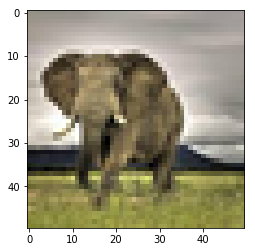

In [80]:
plt.imshow(X_test_ch_last[2])
print(preds[2])
print(y_test_ch_last[2,1])

0
1.0


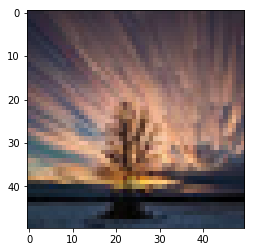

In [81]:
plt.imshow(X_test_ch_last[61])
print(preds[61])
print(y_test_ch_last[61,1])

Da la impresión de que imágenes de exterior con menos luz o imágenes de interior con mucha luz hacen que la red prediga mal

## Part 3: method comparison

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Write a small report comparing the results obtained using the two attempted approaches. What are the advantages and disadvantages of each of them?
 </td></tr>
</table>

Las principales diferencias que he podido notar entre los 2 métodos son:
1. Las SVM son más fáciles de ajustar, ya que tienen menos parámetros y son menos complejas que las redes neuronales.

2. Las SVM tardan menos en entrenar.
    
3. En las SVM lineales es posible ver el impacto de una determinada variable en la predicción.

4. Las redes neuronales obtienen mejor accuracy que las SVM si se van probando y se consigue un modelo apropiado

5. Para determinados problemas, existen redes neuronales específicas que están probadas para esos problemas en particular y se puede partir de allí para obtener un buen modelo.

El preprocesamiento de las imágenes parece ser muy importante para el resultado final. Es posible que el reescalado hecho a las imágenes para las redes neuronales no haya sido el óptimo.